# Care - 2D Example for time points between 390 and 399

Here, the volumetric images from camera CM02 have been flipped and translated. Next, the CM02 images have been registered using hand-picked features. Finally, the second half of the images acquired from CM02 and the first half of images acquired from CM03 are denoised. We ignored the middle slices (30 to 40) and also the extreme slices (0 to 5, 65 to 70) during training.

In [1]:
# We import all our dependencies.
from n2v.models import N2V
import numpy as np
from matplotlib import pyplot as plt
from tifffile import imread, imwrite
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from csbdeep.io import save_tiff_imagej_compatible
from csbdeep.models import CARE
import glob
import copy

Using TensorFlow backend.


In [2]:
# A previously trained model is loaded by creating a new Care object without providing a 'config'.  
model = CARE(config=None, name='care_2D_kellerlab_with_normalization_with_HandRegistration_float64', basedir='models')

Loading network weights from 'weights_best.h5'.


## Load images from CM02. 

In [3]:
filenames = glob.glob("/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM02_flipped/*.tif")
filenames.sort()
imgs = [imread(img).astype('float64') for img in filenames]

print(len(imgs))
print("Typical shape:",  imgs[0].shape)
print("Typical datatype:", imgs[0].dtype)

10
Typical shape: (70, 896, 576)
Typical datatype: float64


In [4]:
X_CM02=[]
for i in range(len(imgs)):
    temp=imgs[i][-35:, ...]
    X_CM02.append(temp)
print(X_CM02[5].shape)

(35, 896, 576)


In [5]:
Y_CM02=[]
for i in range(len(imgs)):
    temp=imgs[i][:35, ...]
    Y_CM02.append(temp)
print(Y_CM02[5].shape)

(35, 896, 576)


In [6]:
filenames = glob.glob("/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM03/*.tif")
filenames.sort()
imgs = [imread(img).astype('float64') for img in filenames]

print("Typical shape:",  imgs[0].shape)
print("Typical datatype:", imgs[0].dtype)

Typical shape: (70, 896, 576)
Typical datatype: float64


In [7]:
X_CM03=[]
for i in range(len(imgs)):
    temp=imgs[i][:35, ...]
    X_CM03.append(temp)
print(X_CM03[5].shape)

(35, 896, 576)


In [8]:
Y_CM03=[]
for i in range(len(imgs)):
    temp=imgs[i][-35:, ...]
    Y_CM03.append(temp)
print(Y_CM03[5].shape)

(35, 896, 576)


In [9]:
imgsX=X_CM02+X_CM03
print(len(imgsX))
print(imgsX[5].shape)

20
(35, 896, 576)


In [10]:
imgsY=Y_CM03+Y_CM02
print(len(imgsY))
print(imgsY[5].shape)

20
(35, 896, 576)


## At this point, we chop off the first and last 60 pixels from the X-dimension and Y-dimension and then normalize, in order to train subsequently

In [11]:
input_train_chopped=[]
for i in range(len(imgsX)):
    input_train_chopped.append(imgsX[i][:, 60:-60, 60:-60])

## Copy the mean and std from the training notebooks

In [12]:
mean=np.array(119.93517382211974).astype('float64')
std=np.array(43.67865414305284).astype('float64')

In [13]:
input_train_chopped_normalized=copy.deepcopy(input_train_chopped)
for i in range(len(input_train_chopped_normalized)):
    input_train_chopped_normalized[i]=(input_train_chopped[i]-mean)/std


In [14]:
pred_train=copy.deepcopy(input_train_chopped_normalized)
for i in range(len(input_train_chopped_normalized)):
    for j in range(input_train_chopped_normalized[i].shape[0]):
        img=input_train_chopped_normalized[i][j, ..., np.newaxis]
        result_image=model.predict(img, axes='YXC', n_tiles=(4,4,1), normalizer= None)
        pred_train[i][j, ..., np.newaxis]=result_image

100%|██████████| 16/16 [00:00<00:00, 28.06it/s]  


100%|██████████| 16/16 [00:00<00:00, 33.10it/s]  


100%|██████████| 16/16 [00:00<00:00, 32.78it/s]  


100%|██████████| 16/16 [00:00<00:00, 32.99it/s]  


100%|██████████| 16/16 [00:00<00:00, 33.41it/s] 


In [15]:
print(len(pred_train))
print(pred_train[0].shape)
print(pred_train[0].dtype)

20
(35, 776, 456)
float64


## Denormalize the predictions

In [16]:
pred_train_denormalized=copy.deepcopy(pred_train)
for i in range(len(pred_train)):
    pred_train_denormalized[i] = pred_train[i]*std + mean

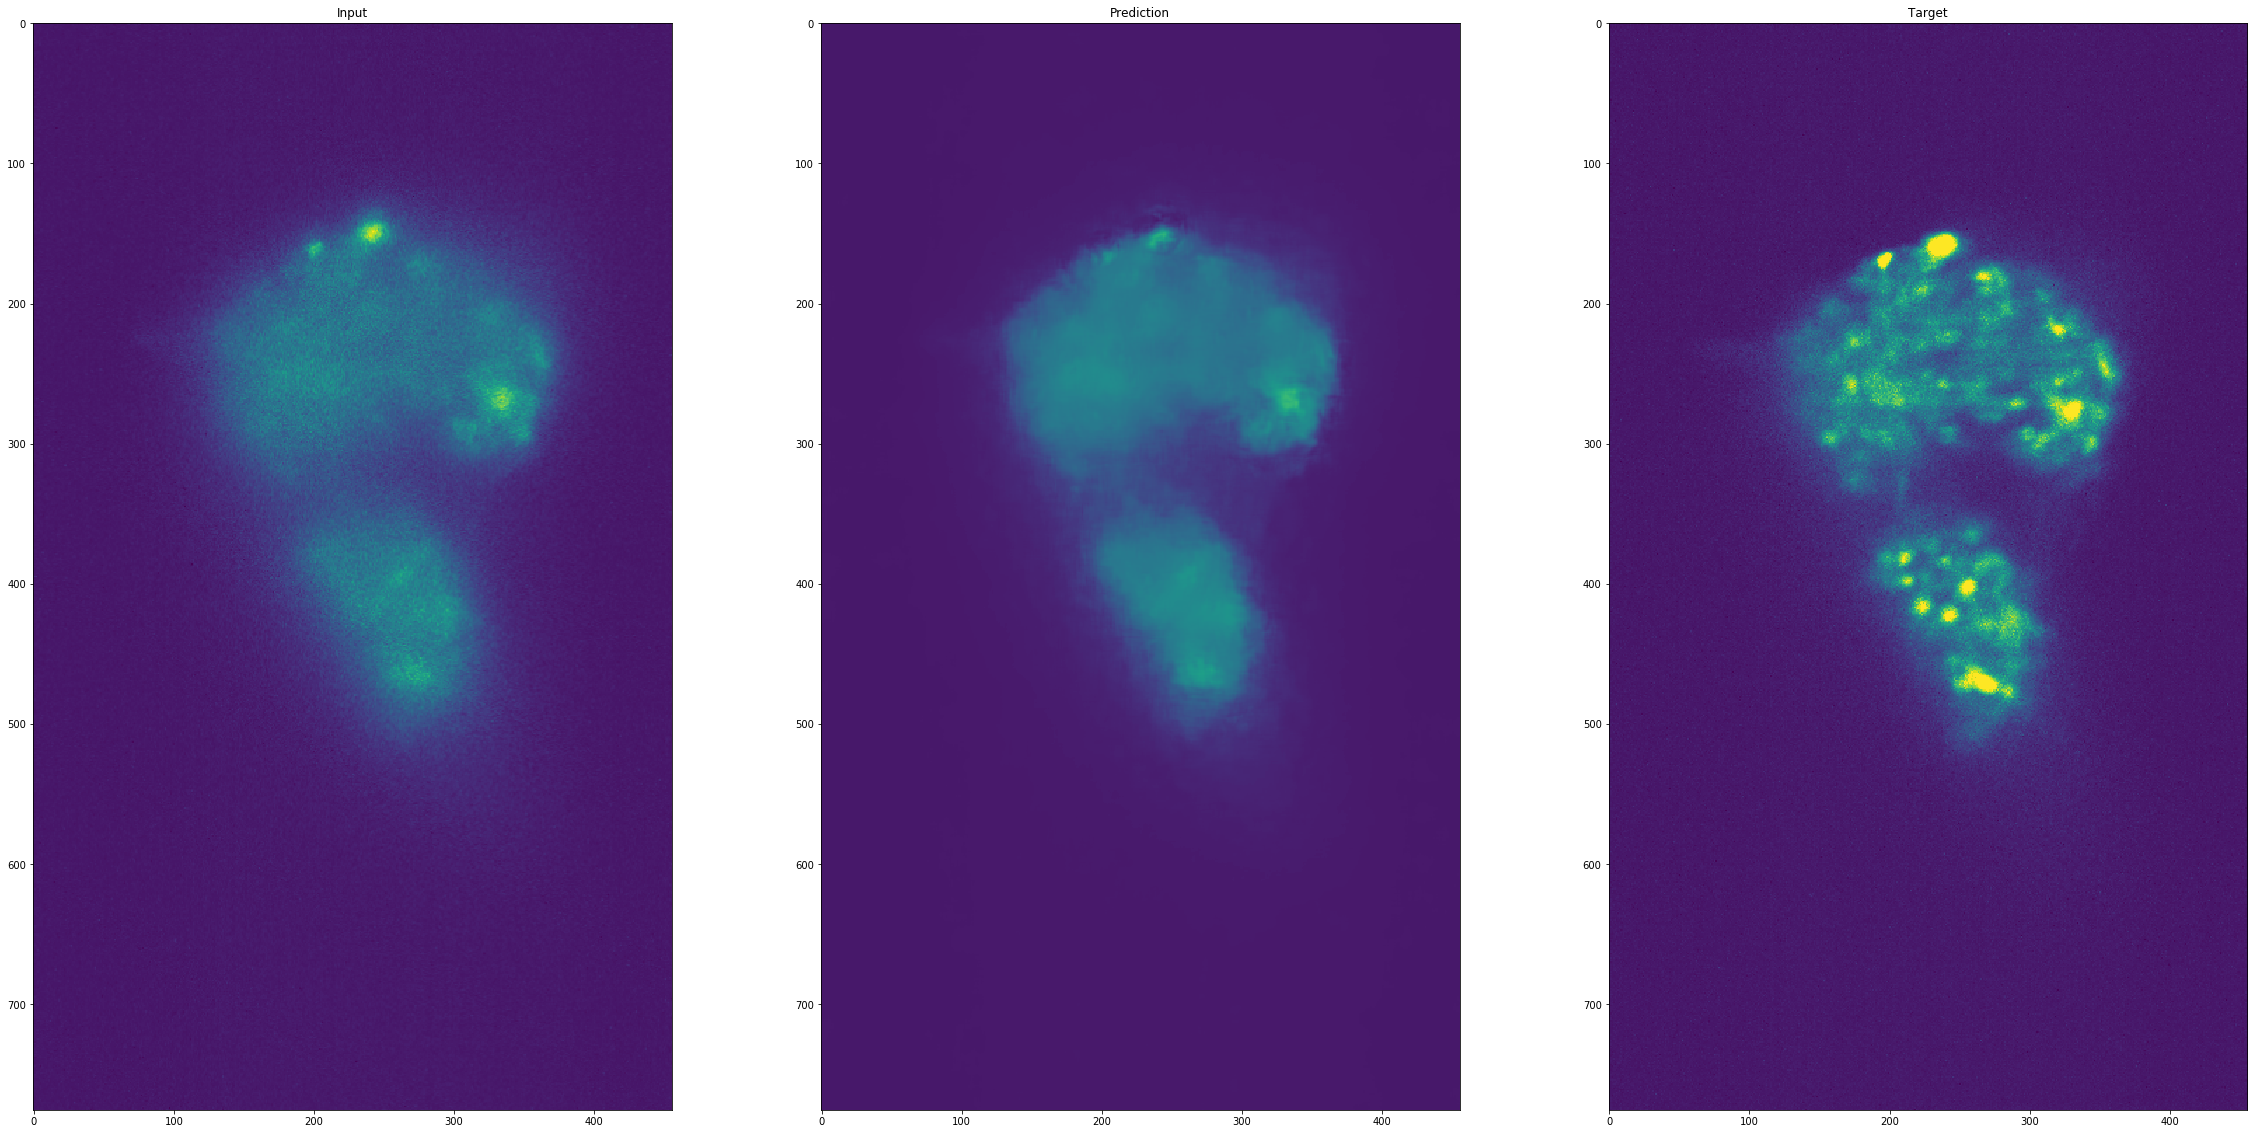

In [30]:
slice=22
vmin=np.min(input_train_chopped[5][slice, ...])
vmax=np.max(input_train_chopped[5][slice, ...])

# Let's look at the results.
plt.figure(figsize=(40,20))
plt.subplot(1,3,1)
plt.imshow(input_train_chopped[5][slice, ...], vmin=vmin, vmax=vmax)
plt.title('Input');

plt.subplot(1,3,2)
plt.imshow(pred_train_denormalized[5][slice, ...], vmin=vmin, vmax=vmax)
plt.title('Prediction');

plt.subplot(1,3,3)
plt.imshow(imgsY[5][slice, 60:-60, 60:-60], vmin=vmin, vmax=vmax)
plt.title('Target');


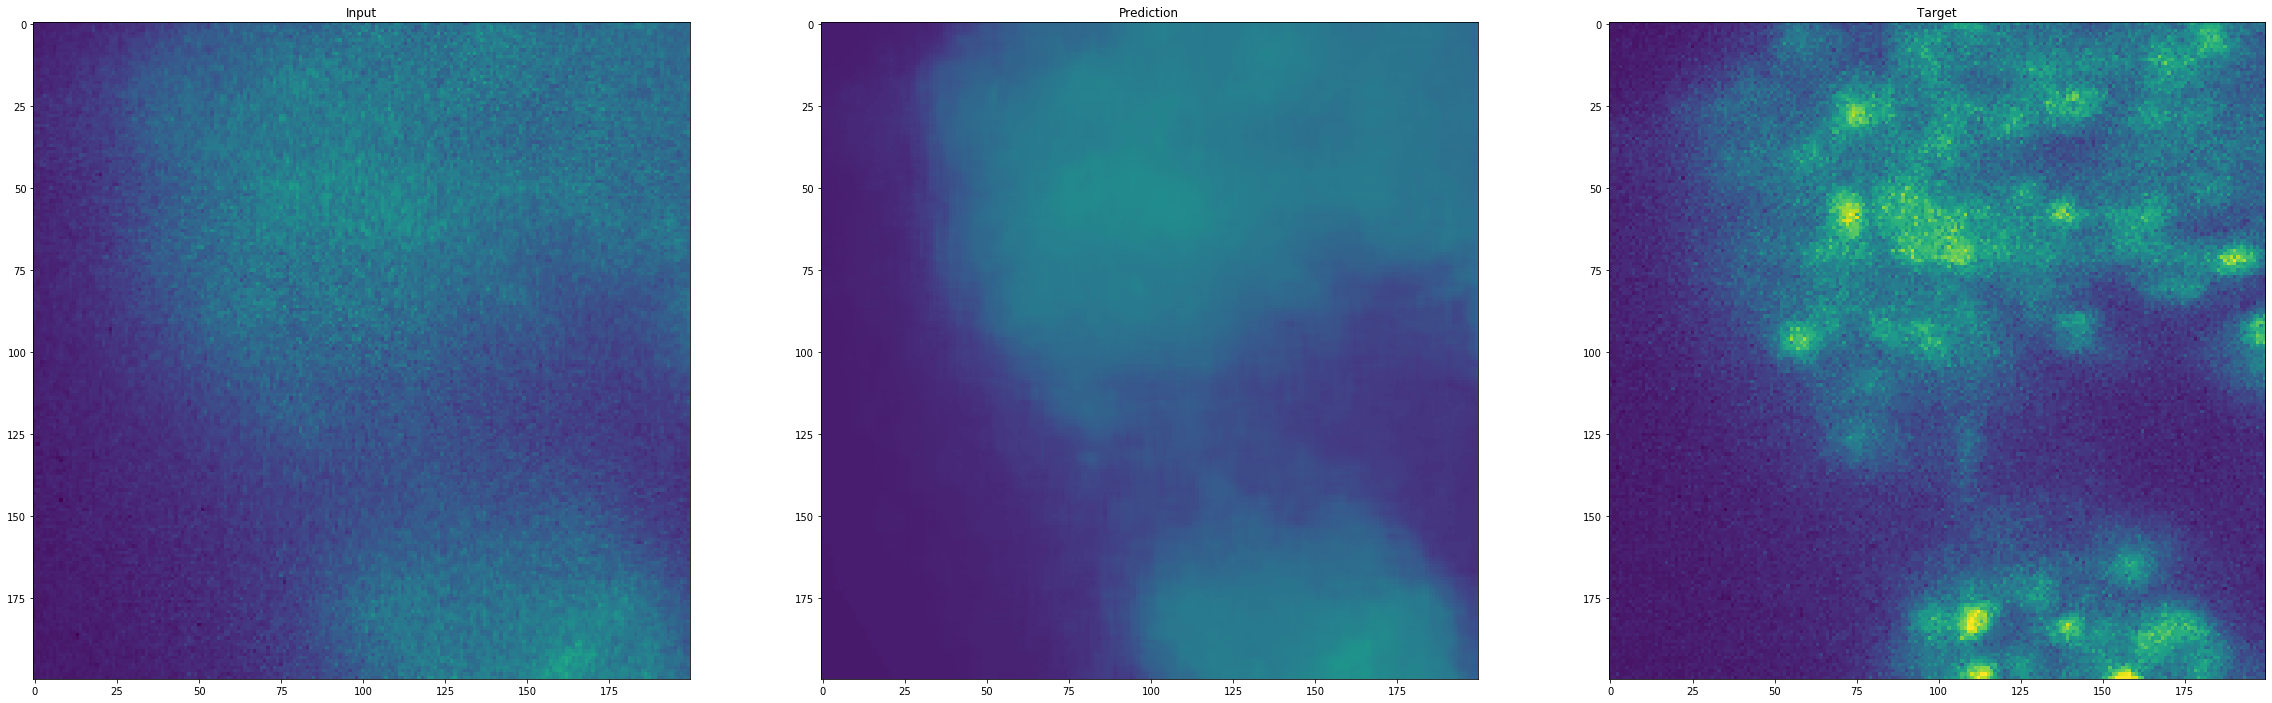

In [31]:
slice=22
ymin=200
ymax=400
xmin=100
xmax=300
vmin=np.min(input_train_chopped[5][slice, ...])
vmax=np.max(input_train_chopped[5][slice, ...])

# Let's look at the results.
plt.figure(figsize=(40,20))
plt.subplot(1,3,1)
plt.imshow(input_train_chopped[5][slice, ymin:ymax, xmin:xmax], vmin=vmin, vmax=vmax)
plt.title('Input');

plt.subplot(1,3,2)
plt.imshow(pred_train_denormalized[5][slice, ymin:ymax, xmin:xmax], vmin=vmin, vmax=vmax)
plt.title('Prediction');

plt.subplot(1,3,3)
imgsYtemp=imgsY[5][:, 60:-60, 60:-60]
plt.imshow(imgsYtemp[slice, ymin:ymax, xmin:xmax], vmin=vmin, vmax=vmax)
plt.title('Target');

## A brief look at how the intensity values have changed after training !

In [18]:

print(np.min(pred_train_denormalized[9][20, ...]))
print(np.max(pred_train_denormalized[9][20, ...]))
print(np.min(input_train_chopped[9][20, ...]))
print(np.max(input_train_chopped[9][20, ...]))


99.88833319715772
628.4356071274477
89.0
840.0


## Reconstitute the images

In [19]:
for i in range(10):
    fileindex=390+i
    print(str(fileindex))
    imwrite("/home/lalit/Desktop/03_Datasets/KellerLab/Data/Denoised/Care_with_proper_normalization_with_pwregistration/16August2019/CM02/"+str(fileindex)+".tif",np.array(pred_train_denormalized[i], dtype='float32'))

390
391
392
393
394
395
396
397
398
399
